## Import delle librerie

In [800]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Estrazione dati dal Dataset e creazione DataFrame

In [801]:
covidDF = pd.read_csv("./dataset/owid-covid-data.csv", encoding='unicode_escape')

# Analisi Covid-19

#### **1)** Verificare le `dimensioni` del dataset e i relativi `metadati`

In [802]:
print(covidDF.shape)
print((covidDF.columns))

(387253, 67)
Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothe

## CLEAN DATA

In [803]:
covidDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387253 entries, 0 to 387252
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    387253 non-null  object 
 1   continent                                   368726 non-null  object 
 2   location                                    387253 non-null  object 
 3   date                                        387253 non-null  object 
 4   total_cases                                 348333 non-null  float64
 5   new_cases                                   376280 non-null  float64
 6   new_cases_smoothed                          375050 non-null  float64
 7   total_deaths                                326109 non-null  float64
 8   new_deaths                                  376589 non-null  float64
 9   new_deaths_smoothed                         375359 non-null  float64
 

In [804]:
# Set date to datetime object
covidDF["date"] = pd.to_datetime(covidDF["date"])
# Rename continent column with region
covidDF.rename(columns={'continent': 'region'}, inplace=True)

# Get location that contains Continent data
naLocation = ['Africa', 'Asia', 'Europe', 'European Union', 'North America', 'Oceania','South America','World']

# Create new continent column with continent data only
covidDF["continent"] = covidDF.loc[(covidDF.location.isin(naLocation)),"location"].fillna("NA").str.replace("European Union","Europe")

# Totals that need to be checked for null
totals = ["total_deaths","total_cases"]
partial = ["new_cases","icu_patients","hosp_patients"]

for column in totals:
    covidDF[column] = covidDF.groupby("location")[column].transform(lambda x: x.interpolate(method="linear").bfill().ffill().fillna(0))

covidDF = covidDF.drop_duplicates(covidDF)

covidDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387253 entries, 0 to 387252
Data columns (total 68 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    387253 non-null  object        
 1   region                                      368726 non-null  object        
 2   location                                    387253 non-null  object        
 3   date                                        387253 non-null  datetime64[ns]
 4   total_cases                                 387253 non-null  float64       
 5   new_cases                                   376280 non-null  float64       
 6   new_cases_smoothed                          375050 non-null  float64       
 7   total_deaths                                387253 non-null  float64       
 8   new_deaths                                  376589 non-null  float64      

#### **2.A)** Per `ogni continente` di trovare `il numero di casi totali` avvenuti in quello stesso continente 
#### **2.B)** Si chiede di non considerare eventuali `locazioni` che nel dataset `non appartengono ad alcun continente`

Text(0, 0.5, 'Casi totali')

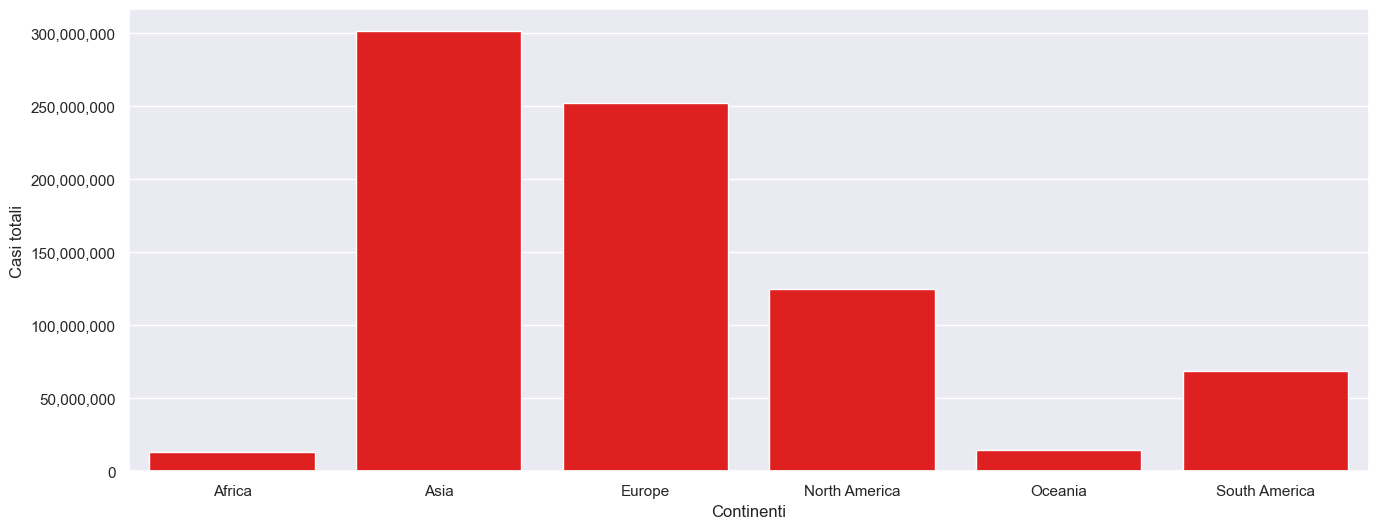

In [805]:
# Data section
not_world = covidDF[~(covidDF.continent == "World")]
total_casesS = not_world.groupby("continent")["total_cases"].max()
sns.set_style()
# Graph section
plt.figure(figsize=(16,6))
barplot =sns.barplot(total_casesS, color='red')
# Get the current axes (ax) from the barplot
ax = barplot.axes
# Format the tick labels on the y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
barplot.set_xlabel("Continenti")
# Set the label for the y-axis
barplot.set_ylabel("Casi totali")


#### **3)** Date `due variabili` contenenti i nomi di `continenti`, ne confronti i seguenti relativi descrittori statistici: `valore massimo, media, e percentuale rispetto` al numero dei `casi totali nel mondo` (calcolati anche sulle locazioni senza indicazione di continente);

In [806]:
#Continenti dell'analisi
cases = ["Europe","North America","World"]

mask = (covidDF.continent.isin(cases))

covidDF[mask].groupby("continent").agg(max=("total_cases",lambda x: format(x.max(), '.0f')),mean=("total_cases",lambda x: format(x.mean(), '.0f')),percent=("total_cases",lambda x: (round(x.max() / covidDF[covidDF.continent == "World"]["total_cases"].max() * 100,0))))    

,max,mean,percent
continent,,,
Europe,252376812,114039499,33.0
North America,124525104,71896751,16.0
World,774954379,399464217,100.0


#### **4.A)** Selezionare i dati relativi all'`Italia nel 2022`, mostrare con un `grafico` l'evoluzione del `casi totali` rispetto alla `data`.
#### **4.B)** Mostrare con un `grafico` il numero di `nuovi casi` rispetto alla `data` (filtrare i dati se necessario).
#### **4.C)** Mostrare infine un `grafico` che mostra l'andamento della `somma cumulativa nuovi casi` del 2022, commentare se ci sono similarità con l'andamento del numero dei `casi totali`;

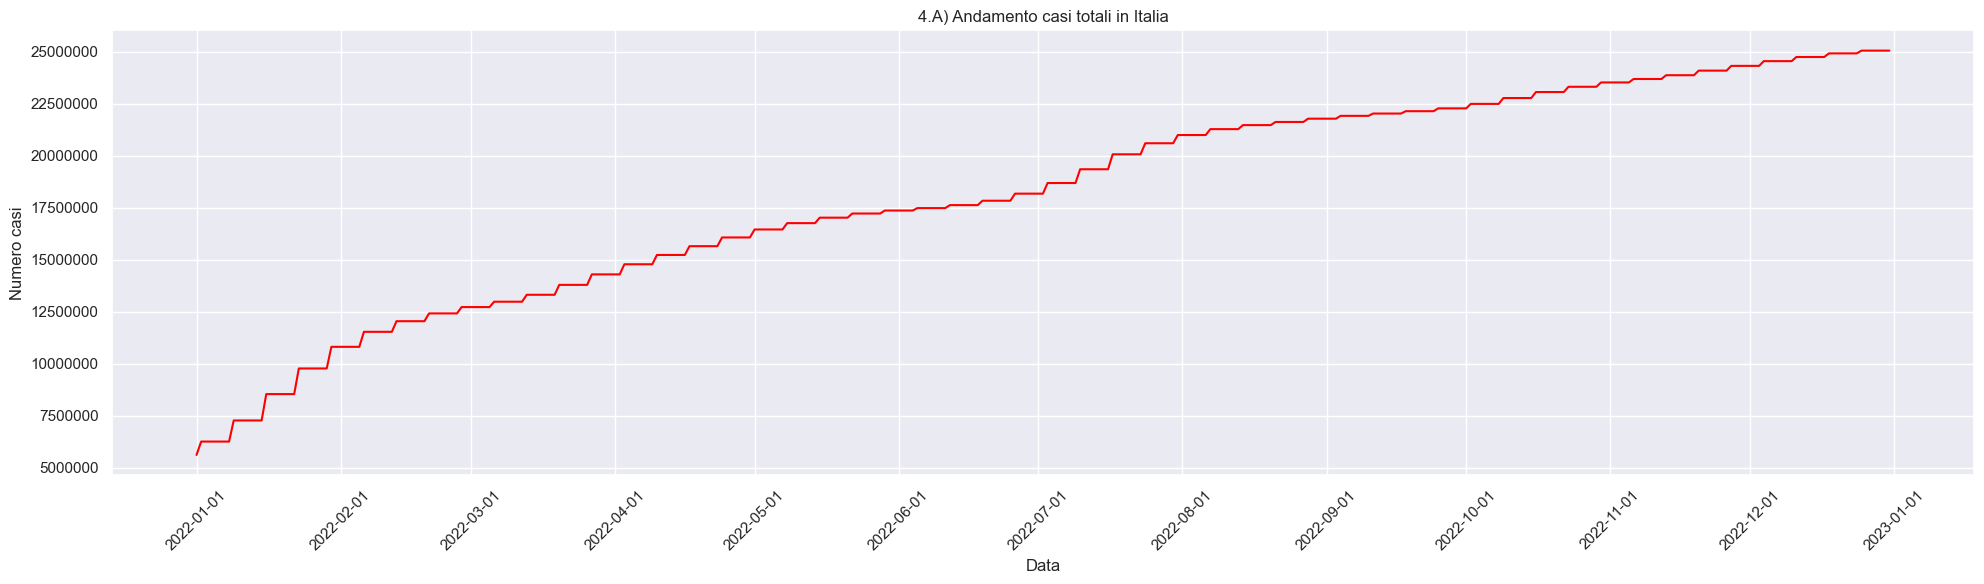

In [807]:
# Data section
italy = covidDF[covidDF.location == "Italy"]
italy_2022 = italy[italy.date.dt.year == 2022]
italy_2022 = italy_2022.sort_values(by='date')

# Palette
countries = ['Italy', 'Germany', 'France','Spain']
palette = palette = {'Italy': 'green', 'Germany': 'yellow', 'France': 'blue','Spain':'purple'}

# Graph section
plt.figure(figsize=(20, 6))
plt.plot(italy_2022['date'], italy_2022['total_cases'], color='red')
# Get the current axes (ax) from the barplot
plt.title('4.A) Andamento casi totali in Italia')
plt.xlabel('Data')
plt.ylabel('Numero casi')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Apply the custom formatter to the y-axis
plt.ticklabel_format(style='plain', axis='y')
# Set x-axis date format and increase detail
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

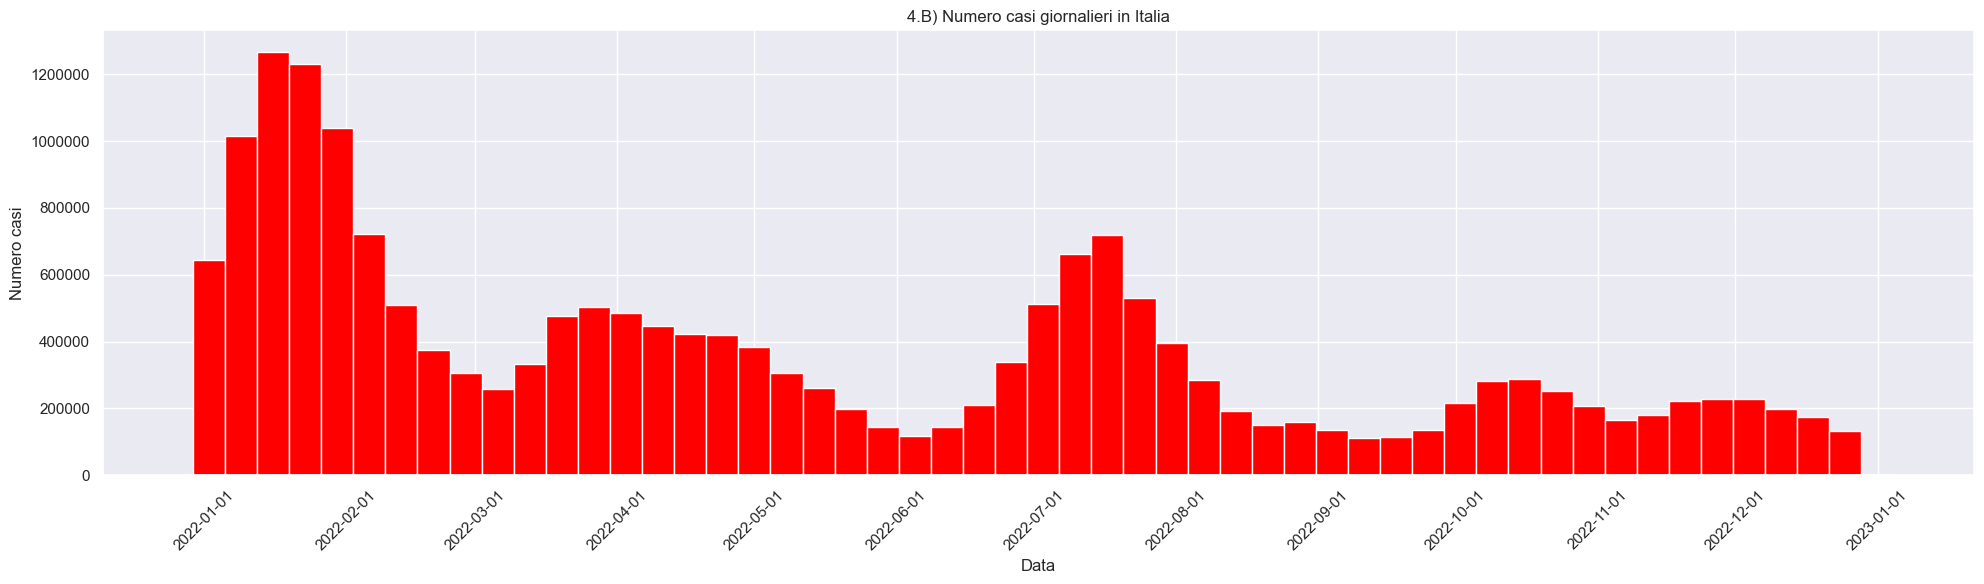

In [808]:
# Graph section
plt.figure(figsize=(20, 6))
plt.bar(italy_2022['date'], italy_2022['new_cases'], color='red', linestyle='-', width=7)
# Get the current axes (ax) from the barplot
plt.title('4.B) Numero casi giornalieri in Italia')
plt.xlabel('Data')
plt.ylabel('Numero casi')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Apply the custom formatter to the y-axis
plt.ticklabel_format(style='plain', axis='y')
# Set x-axis date format and increase detail
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

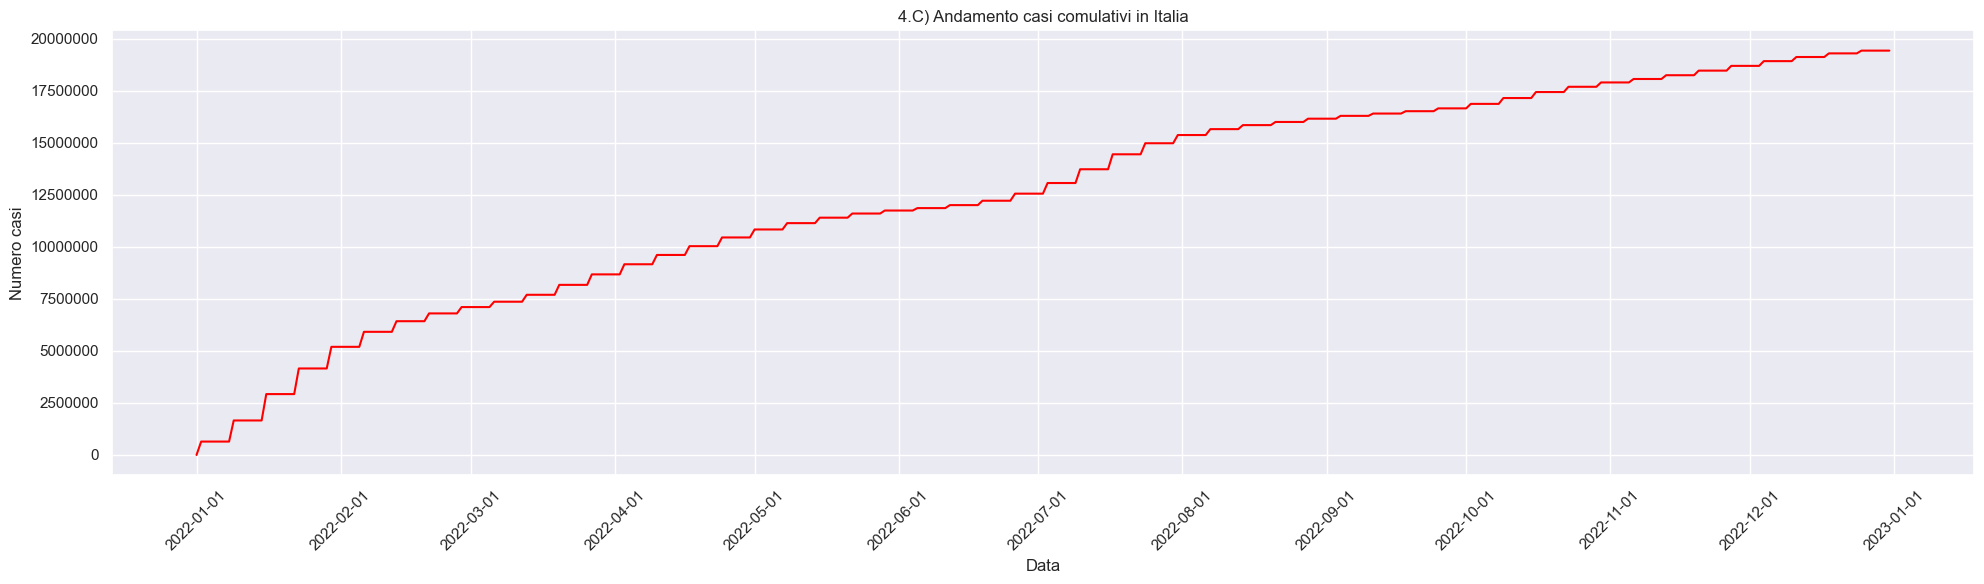

In [809]:
# Data section
italy_2022['cumulative_new_cases'] = italy_2022['new_cases'].cumsum()

# Graph section
plt.figure(figsize=(20, 6))
plt.plot(italy_2022['date'], italy_2022['cumulative_new_cases'], color='red')
# Get the current axes (ax) from the barplot
plt.title('4.C) Andamento casi comulativi in Italia')
plt.xlabel('Data')
plt.ylabel('Numero casi')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Apply the custom formatter to the y-axis
plt.ticklabel_format(style='plain', axis='y')
# Set x-axis date format and increase detail
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

## Analisi 4) C'è una differenza di 50.000 unità tra il valore massimo di total_cases e la somma comulativa di new_cases

#### **5.A)** Riguardo le nazioni di `Italia, Germania e Francia`, mostrare in un `boxplot` la differenza tra queste nazioni riguardo il numero di `pazienti in terapia intensiva` (Intensive Care Unit, ICU) da `maggio 2022` (incluso) ad `aprile 2023` (incluso), scrivere un breve commento a riguardo;

C:\Users\elber\AppData\Local\Temp\ipykernel_11168\4074900700.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='location', y='icu_patients', data=ita_ger_fra,palette=palette)


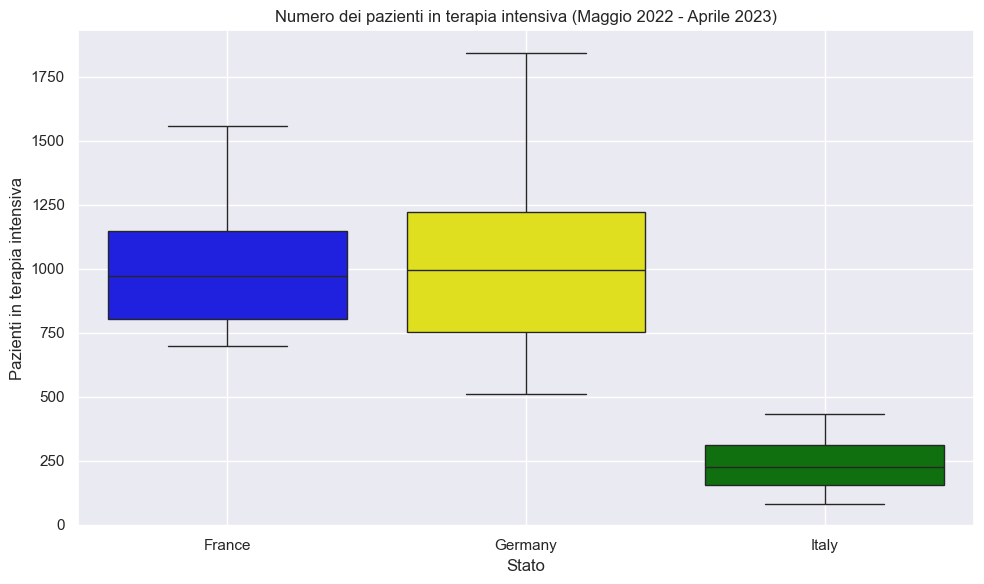

In [810]:
# Data section
countries = ['Italy', 'Germany', 'France']
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-04-30')
ita_ger_fra = covidDF[(covidDF['location'].isin(countries)) & ((covidDF['date'] >= start_date) & (covidDF['date'] <= end_date))]

# Graph section
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='icu_patients', data=ita_ger_fra,palette=palette)
plt.title('Numero dei pazienti in terapia intensiva (Maggio 2022 - Aprile 2023)')
plt.xlabel('Stato')
plt.ylabel('Pazienti in terapia intensiva')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analsisi ICU Patients

Come si puà vedere dal grafico l'Italia ha riportato numeri molto più bassi di pazienti in terapia intensiva rispetto a Germania e Francia.
Il Governo tramite i vari lockdown è riuscito nell'intento di abbassare il tasso di contagio, di conseguenza il numero di casi in terapie intensive.
L'Italia è riuscita così ad uscire prima dal circolo vizioso chaimato Covid-19.

#### **6.A)** Riguardo le nazioni di `Italia, Germania e Francia` nel `2023`, mostrare la `somma dei pazienti` ospitalizzati per ognuna -- se ci sono dati nulli, suggerire se può essere possbile gestirli tramite sostituzione o meno

C:\Users\elber\AppData\Local\Temp\ipykernel_11168\3736722502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='location', y='hosp_patients', data=ita_ger_fra, color='purple', palette=palette)


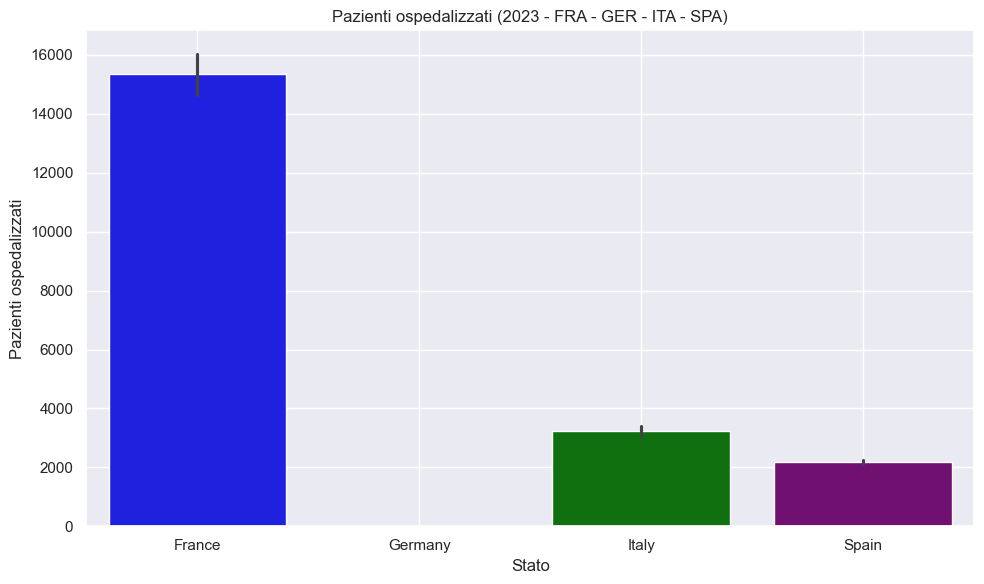

In [811]:
# Data section
countries = ['Italy', 'Germany', 'France','Spain']
ita_ger_fra = covidDF[(covidDF['location'].isin(countries)) & (covidDF['date'].dt.year ==2023)]

# Graph section
plt.figure(figsize=(10, 6))
sns.barplot(x='location', y='hosp_patients', data=ita_ger_fra, color='purple', palette=palette)
plt.title('Pazienti ospedalizzati (2023 - FRA - GER - ITA - SPA)')
plt.xlabel('Stato')
plt.ylabel('Pazienti ospedalizzati')
plt.grid(True)
plt.tight_layout()
plt.show()

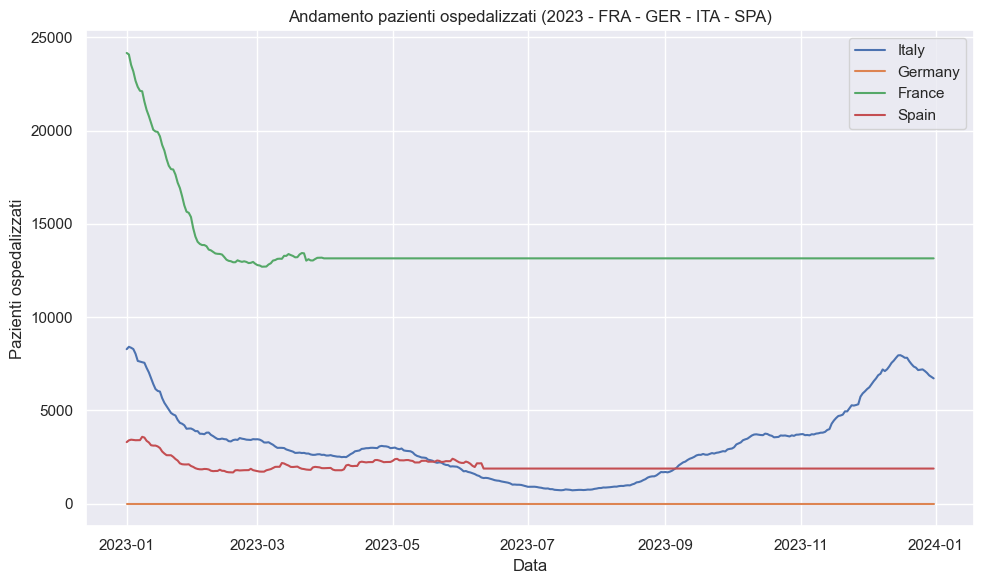

In [816]:
ita_ger_fra = covidDF[(covidDF['location'].isin(countries)) & (covidDF['date'].dt.year == 2023)]

# Graph section
plt.figure(figsize=(10, 6))

# Loop through each country and plot its hospital patients' flow
for country in countries:
    country_data = ita_ger_fra[ita_ger_fra['location'] == country]
    plt.plot(country_data['date'], country_data['hosp_patients'], label=country)

plt.title('Andamento pazienti ospedalizzati (2023 - FRA - GER - ITA - SPA)')
plt.xlabel('Data')
plt.ylabel('Pazienti ospedalizzati')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Fine analisi
## il riempimento dei NaN per i totali è stato gestito subito dopo l'estrazione del dataset nella sezione delimitata del Markdown CLEAN DATA
## Essendo i icu_patients e hosp_patients numeri giornalieri quindi con una bassa correlazione sul precedente/successivo, aggiungendoci che per 3 stati su 4 i dati sono assenti per metà almeno l'analisi non riesce ad essere efficace per la porzione di dati scelta. La stessa analisi ribaltata nel 2022 ottiene molta più valenza avendo per 3 stati su 4 i dati al completo. L'unica soluzione optabile sarebbe chiedere alla Germania di avere più tracciabilità nei referti medici.

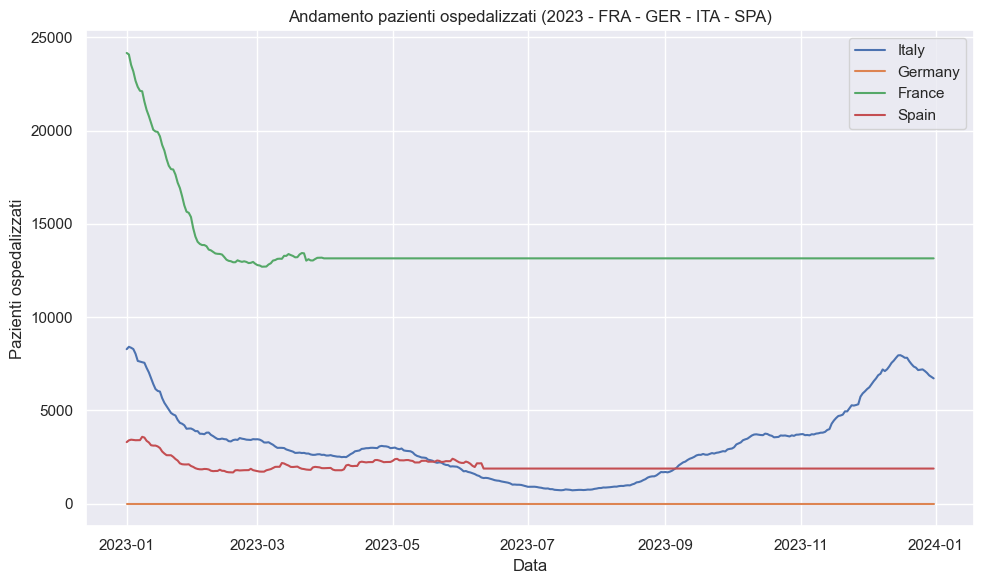

In [817]:
for column in partial:
    covidDF[column] = covidDF.groupby("location")[column].transform(lambda x: x.interpolate(method="linear").fillna(0))
    
countries = ['Italy', 'Germany', 'France','Spain']
ita_ger_fra = covidDF[(covidDF['location'].isin(countries)) & (covidDF['date'].dt.year == 2023)]

# Graph section
plt.figure(figsize=(10, 6))

# Loop through each country and plot its hospital patients' flow
for country in countries:
    country_data = ita_ger_fra[ita_ger_fra['location'] == country]
    plt.plot(country_data['date'], country_data['hosp_patients'], label=country)

plt.title('Andamento pazienti ospedalizzati (2023 - FRA - GER - ITA - SPA)')
plt.xlabel('Data')
plt.ylabel('Pazienti ospedalizzati')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

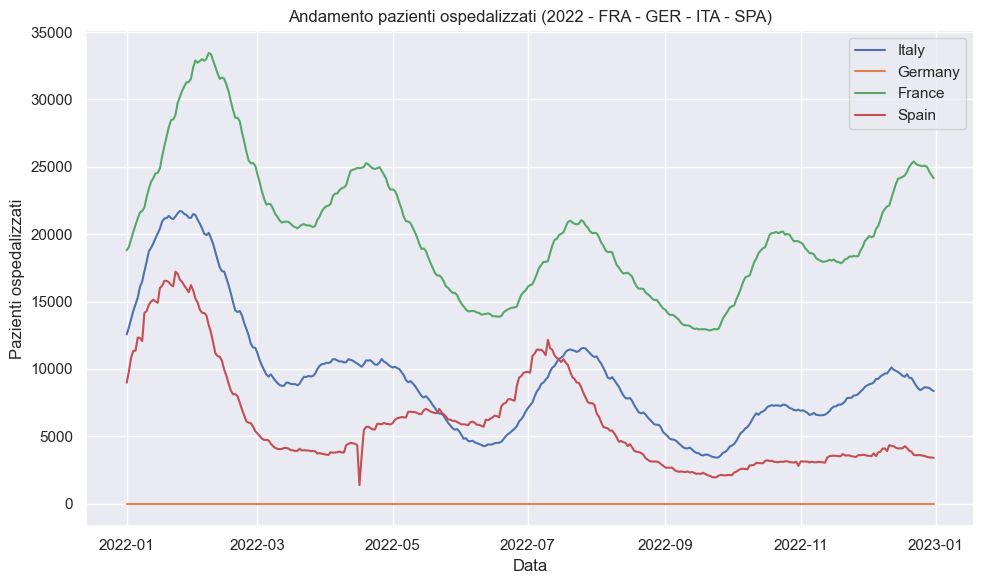

In [814]:
countries = ['Italy', 'Germany', 'France','Spain']
ita_ger_fra = covidDF[(covidDF['location'].isin(countries)) & (covidDF['date'].dt.year == 2022)]

# Graph section
plt.figure(figsize=(10, 6))

# Loop through each country and plot its hospital patients' flow
for country in countries:
    country_data = ita_ger_fra[ita_ger_fra['location'] == country]
    plt.plot(country_data['date'], country_data['hosp_patients'], label=country)

plt.title('Andamento pazienti ospedalizzati (2022 - FRA - GER - ITA - SPA)')
plt.xlabel('Data')
plt.ylabel('Pazienti ospedalizzati')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()